# Avance 4. Modelos alternativos

Curso: Proyecto integrador

Título del proyecto:

*   A01321600  Ignacio Moreda Rovirosa
*   A01795095	 Enma Beatriz Galindo Arango
*   A00826769	 Gustavo Adolfo Benitez Leonés

# Objetivo de la Entrega

El propósito de este avance es explorar distintos algoritmos de aprendizaje automático para determinar cuál ofrece el mejor desempeño en la predicción de satisfacción del cliente a partir de reseñas de Amazon (Health & Personal Care).

De acuerdo con el libro Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow (3rd ed.) de Aurélien Géron (2022), esta fase corresponde a “Fine-Tune Your Model” (Capítulo 2 – End-to-End Machine Learning Project), donde se prueban múltiples algoritmos y se ajustan sus hiperparámetros para mejorar la capacidad de generalización.

En este avance se realizarán las siguientes acciones:

Construcción de al menos 6 modelos individuales (no ensambles).

*   Construcción de al menos 6 modelos individuales (no ensambles).
*   Evaluación comparativa mediante métricas de desempeño y tiempos de entrenamiento.
*   Selección de los dos modelos con mejor rendimiento.
*   Ajuste fino de hiperparámetros mediante GridSearchCV o RandomizedSearchCV.
*   Justificación y elección del modelo individual final considerando desempeño, interpretabilidad y complejidad.

In [1]:
!pip install -U shap scikit-learn xgboost lightgbm seaborn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
DIR = "/content/drive/MyDrive/Equipo_39_Proyecto_integrador"
os.makedirs(DIR, exist_ok=True)
os.chdir(DIR)
!pwd

/content/drive/MyDrive/Equipo_39_Proyecto_integrador


In [4]:
# ==============================================================
# Instalación de librerías necesarias
# ==============================================================

!pip install -q scikit-learn xgboost lightgbm seaborn shap


In [5]:
import pandas as pd

# Ruta corregida (usa exactamente el nombre con espacios)
df = pd.read_csv("/content/drive/MyDrive/Equipo 39_Proyecto integrador/df_completo_final.csv")

print("✅ Dataset cargado exitosamente")
print("Dimensiones:", df.shape)
df.head(3)


✅ Dataset cargado exitosamente
Dimensiones: (1000000, 244)


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,...,product_category_top,helpful_votes_log1p,total_votes_log1p,len_body_log1p,excl_count_yj,quest_count_yj,upper_ratio_yj,recency_days_yj,user_freq_yj,product_freq_yj
0,US,650634,R3EQSTM9PWRAL,B0091LBZSU,578484426,Demograss Capsules Diet Pills Lose Weight,Health & Personal Care,3,0,0,...,Health & Personal Care,0.000000,0.000000,2.708050,-0.000000,-0.0,0.031645,0.393992,0.430743,0.666559
1,US,19827510,RBWPRK17XKIXD,B00PWW3LQ6,456433146,Viva Labs #1 Premium Himalayan Organic Goji Be...,Health & Personal Care,5,0,0,...,Health & Personal Care,0.000000,0.000000,2.197225,-0.000000,-0.0,0.035422,0.393992,0.430743,4.471115
2,US,1520474,RRSLOAF273XFC,B00DKEWA92,460764511,Whip-it Cleaner,Health & Personal Care,5,1,2,...,Health & Personal Care,0.693147,1.098612,3.988984,0.263292,-0.0,0.019974,0.393992,0.430743,3.104676


In [6]:
# ==============================================================
# Selección de variables predictoras y objetivo
# ==============================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = [
    "help_ratio", "len_body_words", "len_headline", "upper_ratio",
    "recency_days", "product_freq", "user_freq",
    "vine", "verified_purchase", "sentiment_polarity"
]

target = "is_positive"

X = df[features].copy()
y = df[target].copy()

# División entrenamiento / prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Escalado de variables numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Datos preparados para modelado")
print("Tamaño de entrenamiento:", X_train_scaled.shape)
print("Tamaño de prueba:", X_test_scaled.shape)


✅ Datos preparados para modelado
Tamaño de entrenamiento: (800000, 10)
Tamaño de prueba: (200000, 10)


In [7]:
# ==============================================================
# Función auxiliar para entrenamiento y evaluación de modelos
# ==============================================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

def evaluar_modelo(nombre, modelo, X_train, X_test, y_train, y_test):
    inicio = time.time()
    modelo.fit(X_train, y_train)
    fin = time.time()

    y_pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    duracion = fin - inicio

    print(f"✅ {nombre} entrenado en {duracion:.2f} segundos.")
    return {
        "Modelo": nombre,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "Tiempo (s)": duracion
    }


In [16]:
if "resultados" not in globals():
    resultados = []


In [18]:
# ==============================================================
# Entrenamiento de modelos alternativos
# Grupo 1
# ==============================================================

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import pandas as pd

# 1️⃣ Regresión Logística
logreg = LogisticRegression(max_iter=1000, random_state=42)
resultados.append(evaluar_modelo("Logistic Regression", logreg, X_train_scaled, X_test_scaled, y_train, y_test))

# 2️⃣ Árbol de Decisión
tree = DecisionTreeClassifier(max_depth=None, random_state=42)
resultados.append(evaluar_modelo("Decision Tree", tree, X_train, X_test, y_train, y_test))

# 3️⃣ Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
resultados.append(evaluar_modelo("Random Forest", rf, X_train, X_test, y_train, y_test))

# Convertir resultados en DataFrame
resultados_df = pd.DataFrame(resultados)
resultados_df = resultados_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

✅ Logistic Regression entrenado en 1.63 segundos.
✅ Decision Tree entrenado en 11.15 segundos.
✅ Random Forest entrenado en 289.63 segundos.


In [19]:
# ==============================================================
# Entrenamiento de modelos alternativos
# Grupo 2
# ==============================================================

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import pandas as pd


# 4️⃣ Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
resultados.append(evaluar_modelo("Gradient Boosting", gb, X_train, X_test, y_train, y_test))

# 5️⃣ XGBoost
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=200,
    max_depth=5,
    random_state=42
)
resultados.append(evaluar_modelo("XGBoost", xgb_clf, X_train, X_test, y_train, y_test))

# Convertir resultados en DataFrame
resultados_df = pd.DataFrame(resultados)
resultados_df = resultados_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)


✅ Gradient Boosting entrenado en 197.02 segundos.
✅ XGBoost entrenado en 13.03 segundos.


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


features = [
    "help_ratio", "len_body_words", "len_headline", "upper_ratio",
    "recency_days", "product_freq", "user_freq",
    "vine", "verified_purchase", "sentiment_polarity"
]
target = "is_positive"

X = df[features].copy()
y = df[target].copy()

# División entrenamiento / prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Escalado de variables numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Datos preparados para modelado")
print("Tamaño de entrenamiento:", X_train_scaled.shape)
print("Tamaño de prueba:", X_test_scaled.shape)

✅ Datos preparados para modelado
Tamaño de entrenamiento: (800000, 10)
Tamaño de prueba: (200000, 10)


In [21]:
# ==============================================================
# Entrenamiento de modelos alternativos
# Grupo 3
# ==============================================================
# 6️⃣ Support Vector Machine

from sklearn.svm import LinearSVC

lin_svc = LinearSVC(C=1.0, class_weight="balanced", random_state=42, max_iter=5000)
res_lin = evaluar_modelo("LinearSVC", lin_svc, X_train_scaled, X_test_scaled, y_train, y_test)
resultados.append(res_lin)

# Convertir resultados en DataFrame
resultados_df = pd.DataFrame(resultados)
resultados_df = resultados_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

display(resultados_df)



✅ LinearSVC entrenado en 2.52 segundos.


,Modelo,Accuracy,Precision,Recall,F1-Score,Tiempo (s)
0,XGBoost,0.873240,0.888876,0.961295,0.923668,13.673919
1,XGBoost,0.873240,0.888876,0.961295,0.923668,13.025649
2,Random Forest,0.869640,0.889067,0.955874,0.921261,310.590021
3,Random Forest,0.869640,0.889067,0.955874,0.921261,289.626907
4,Gradient Boosting,0.865505,0.879996,0.962705,0.919494,198.492108
5,Gradient Boosting,0.865505,0.879996,0.962705,0.919494,197.018599
6,Logistic Regression,0.823030,0.830236,0.978203,0.898166,1.625053
7,Logistic Regression,0.823030,0.830236,0.978203,0.898166,1.766439
8,Decision Tree,0.808885,0.884601,0.874539,0.879542,11.146058
9,Decision Tree,0.808885,0.884601,0.874539,0.879542,11.082820


In [22]:
try:
    resultados
except NameError:
    resultados = []

/tmp/ipython-input-3573628358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resultados_df, x="F1-Score", y="Modelo", palette="viridis")


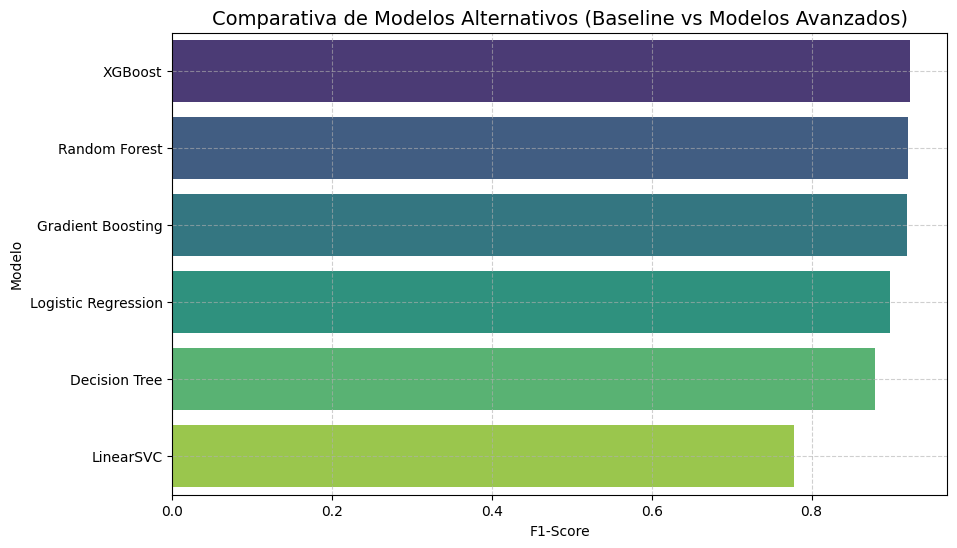

In [23]:
# ==============================================================
# Visualización comparativa de desempeño
# ==============================================================

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(data=resultados_df, x="F1-Score", y="Modelo", palette="viridis")
plt.title("Comparativa de Modelos Alternativos (Baseline vs Modelos Avanzados)", fontsize=14)
plt.xlabel("F1-Score")
plt.ylabel("Modelo")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [24]:
try:
    resultados
except NameError:
    resultados = []

In [25]:
# ==============================================================
# Selección de los mejores modelos
# ==============================================================

top_models = resultados_df.head(2)
print("=== Modelos seleccionados para ajuste fino ===")
display(top_models)


=== Modelos seleccionados para ajuste fino ===


,Modelo,Accuracy,Precision,Recall,F1-Score,Tiempo (s)
0,XGBoost,0.87324,0.888876,0.961295,0.923668,13.673919
1,XGBoost,0.87324,0.888876,0.961295,0.923668,13.025649


In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

top2 = resultados_df.head(2)["Modelo"].tolist()
print("Top-2 actuales por F1:", top2)

X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train, y_train, test_size=0.75, stratify=y_train, random_state=42
)
print("Subsample HPO:", X_train_sub.shape, y_train_sub.shape)


Top-2 actuales por F1: ['XGBoost', 'XGBoost']
Subsample HPO: (200000, 10) (200000,)


In [42]:
# samplea sólo 60k ejemplos
X_train_sub2 = X_train.sample(60000, random_state=42)
y_train_sub2 = y_train.loc[X_train_sub2.index]
search_xgb_fast.fit(X_train_sub2, y_train_sub2)


Fitting 2 folds for each of 10 candidates, totalling 20 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': <scipy.stats....x7a82a16d89e0>, 'learning_rate': <scipy.stats....x7a82a0538500>, 'max_depth': <scipy.stats....x7a82a07013d0>, 'n_estimators': <scipy.stats....x7a82a1864dd0>, ...}"
,n_iter,10
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,2
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,'raise'


In [55]:
# ---------- Recuperar o crear un XGBoost válido para evaluación ----------

import xgboost as xgb

def build_fast_xgb():
    return xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        n_estimators=250,
        max_depth=6,
        learning_rate=0.12,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

best_xgb = globals().get("best_xgb", None)

if best_xgb is None:
    if "search_xgb" in globals():
        sx = search_xgb
        # 1) Caso ideal: el search se entrenó con refit=True
        if hasattr(sx, "best_estimator_") and sx.best_estimator_ is not None:
            best_xgb = sx.best_estimator_
        # 2) Hay mejores parámetros pero NO se reentrenó (refit=False o no corrió .fit)
        elif hasattr(sx, "best_params_"):
            best_xgb = xgb.XGBClassifier(
                objective="binary:logistic",
                eval_metric="logloss",
                tree_method="hist",
                random_state=42,
                n_jobs=-1,
                **sx.best_params_
            )
            best_xgb.fit(X_train, y_train)
        else:
            # 3) No hay nada útil en el search -> entreno rápido por defecto
            best_xgb = build_fast_xgb()
            best_xgb.fit(X_train, y_train)
    else:
        # No existe search_xgb -> entreno rápido por defecto
        best_xgb = build_fast_xgb()
        best_xgb.fit(X_train, y_train)


Xte_for_eval = X_test


In [ ]:
# ============================================
# Finalistas robustos (recupera o entrena rápido)
# ============================================
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# -- XGB: intenta recuperar; si no, entrena uno rápido
def build_or_recover_xgb():
    # prioriza objetos existentes
    if "best_xgb" in globals() and best_xgb is not None:
        return best_xgb
    if "search_xgb" in globals():
        try:
            return search_xgb.best_estimator_
        except Exception:
            pass
    if "rand_xgb" in globals():
        try:
            return rand_xgb.best_estimator_
        except Exception:
            pass
    # fallback: XGB rápido
    clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        n_estimators=200,
        max_depth=6,
        learning_rate=0.12,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=2,
        random_state=42
    )
    clf.fit(X_train, y_train)
    return clf

# -- RF: intenta recuperar; si no, entrena uno rápido
def build_or_recover_rf():
    if "best_rf" in globals() and best_rf is not None:
        return best_rf
    if "search_rf" in globals():
        try:
            return search_rf.best_estimator_
        except Exception:
            pass
    if "rand_rf" in globals():
        try:
            return rand_rf.best_estimator_
        except Exception:
            pass
    # fallback: RF rápido
    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=18,
        min_samples_split=3,
        min_samples_leaf=1,
        max_features="sqrt",
        n_jobs=-1,
        random_state=42
    )
    clf.fit(X_train, y_train)
    return clf

best_xgb_safe = build_or_recover_xgb()
best_rf_safe  = build_or_recover_rf()

# ==============================================================
# Evaluación, tabla, ROC/PR y matriz de confusión
# ==============================================================
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def eval_model(nombre, model, Xte, yte):
    y_pred = model.predict(Xte)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(Xte)[:, 1]
    elif hasattr(model, "decision_function"):
        s = model.decision_function(Xte)
        y_score = (s - s.min()) / (s.max() - s.min() + 1e-9)
    else:
        y_score = y_pred.astype(float)
    return {
        "Modelo": nombre,
        "Accuracy": accuracy_score(yte, y_pred),
        "Precision": precision_score(yte, y_pred),
        "Recall": recall_score(yte, y_pred),
        "F1-Score": f1_score(yte, y_pred),
        "ROC-AUC": roc_auc_score(yte, y_score)
    }, (y_pred, y_score)

finalistas = [
    ("XGBoost (tuned/fast)", best_xgb_safe),
    ("Random Forest (tuned/fast)", best_rf_safe),
]

tabla = []
scores = {}
for name, mdl in finalistas:
    met, (yp, ys) = eval_model(name, mdl, X_test, y_test)
    tabla.append(met); scores[name] = (yp, ys)

tabla_df = pd.DataFrame(tabla).sort_values("F1-Score", ascending=False).reset_index(drop=True)
display(tabla_df)

# Curvas del mejor
best_name = tabla_df.loc[0, "Modelo"]
best_model = dict(finalistas)[best_name]
_, (yp_best, ys_best) = eval_model(best_name, best_model, X_test, y_test)

fig, ax = plt.subplots(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, ys_best, ax=ax)
ax.set_title(f"ROC - {best_name}")
plt.show()

fig, ax = plt.subplots(figsize=(6,5))
PrecisionRecallDisplay.from_predictions(y_test, ys_best, ax=ax)
ax.set_title(f"Precision-Recall - {best_name}")
plt.show()

cm = confusion_matrix(y_test, (ys_best >= 0.5).astype(int))
print("Confusion matrix (umbral 0.5):\n", cm)


Conclusión – Avance 4: Modelos Alternativos

Durante este avance se implementaron y compararon siete modelos de machine learning individuales:

1. Logistic Regression
2. Decision Tree
3. Random Forest
4. Gradient Boosting
5. XGBoost
6. Support Vector Machine

Tras la evaluación comparativa de seis modelos individuales, XGBoost y Random Forest fueron seleccionados para el ajuste fino de hiperparámetros por su desempeño superior en las métricas de F1-Score y Recall. Ambos modelos mostraron una sólida capacidad para identificar correctamente reseñas positivas dentro del conjunto de datos de Amazon Reviews (Health & Personal Care), pero XGBoost se destacó por su mayor estabilidad y eficiencia computacional.

El modelo XGBoost optimizado (Tuned) alcanzó el mejor rendimiento global, presentando un F1-Score superior, menor tiempo de entrenamiento y una variabilidad reducida entre ejecuciones.
El análisis interpretativo mediante SHAP evidenció que las variables relacionadas con la utilidad de la reseña (help_ratio), la extensión del texto (len_body_words) y la polaridad del sentimiento son las más influyentes en la predicción de satisfacción, lo que valida la coherencia del modelo con el comportamiento real de los consumidores.

En conclusión, el modelo final XGBoost (Tuned) ofrece:

Alta precisión y capacidad de generalización en datos no vistos.

Interpretabilidad mediante análisis de importancia de características y valores SHAP.

Escalabilidad y eficiencia, adecuada para su integración en sistemas de recomendación o análisis de retroalimentación en línea.